In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# import tensorflow_addons as tfa
# import tqdm

import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

In [3]:
# import imgaug as ia
# from imgaug import augmenters as iaa

In [4]:
import os
from datetime import datetime
import time
from pprint import pprint

In [5]:
# plt.ioff()  # interactive mode off
# plt.ion()  # interactive mode on

# %pylab inline

np.random.seed(1728)
# ia.random.seed(1728)

In [6]:
import time

def mulai_hitung_waktu():
    global waktu_mulai
    waktu_mulai = time.time()

def cetak_lama_waktu():
    global waktu_mulai
    hasil_detik = abs(waktu_mulai - time.time())
    hasil_milidetik = hasil_detik * 1000
    
    menit = hasil_detik / 60
    detik = hasil_detik % 60
    
    menit_detik = str(int(menit)) + 'm' + ':' + str(int(detik)) + 's'
    
    print('-----\n(%.2f ms) == (%s)\n-----' % (hasil_milidetik, menit_detik))
    del waktu_mulai


# cara pakai
# ----------
mulai_hitung_waktu()  ###

time.sleep(100/1000)  # time-consuming computing here

cetak_lama_waktu()  ###

-----
(114.01 ms) == (0m:0s)
-----


In [7]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print("Num GPUs Available: %d Physical GPUs, %d Logical GPU" % (len(gpus), len(logical_gpus)))
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available: 1 Physical GPUs, 1 Logical GPU


In [10]:
BASE_DIR = r'D:\MaskTheFace\datasets\_temp'
TRAIN_SET_PATH = r'D:\MaskTheFace\datasets\_temp\_v1'
TEST_SET_PATH = r'D:\MaskTheFace\datasets\_temp\_v1 - test only'

FINAL_EPOCH_DIR = r'D:\MaskTheFace\datasets\_temp\weights and models'
CHECKPOINTS_DIR = r'D:\MaskTheFace\datasets\_temp\checkpoints'

# Set working directory
os.chdir(BASE_DIR)

print('current work dir:')
print(os.getcwd())
print()
print('listdir WORK_DIR:')
pprint(os.listdir('./'))

current work dir:
D:\MaskTheFace\datasets\_temp

listdir WORK_DIR:
['Augmented Images - Masked',
 'Augmented Images - Masked.zip',
 'Augmented Images - Unmasked',
 'Augmented Images - Unmasked.zip',
 'checkpoints',
 'history',
 'main, train set - crop masked resized',
 'main, train set - crop masked resized.zip',
 'main, train set - crop resized',
 'main, train set - crop resized.zip',
 'note.txt',
 'thumbnails - augmented masked.zip',
 'thumbnails - augmented unmasked.zip',
 'weights and models',
 '_v1',
 '_v1 - test only',
 '_v1.7z']


In [9]:
names = os.listdir(TRAIN_SET_PATH)

length_dict = {}
for name in names:
    samples = f'{TRAIN_SET_PATH:s}/{name:s}'
    length_dict[name] = len(os.listdir(samples))

n_min = min(length_dict.values())
n_max = max(length_dict.values())
n_sum = sum(length_dict.values())

print(f'{len(names):d} names')
display(length_dict)
print(f"max: {n_max:d}")
print(f"min: {n_min:d}")
print(f"total: {n_sum:d}")

# del n_min, n_max, n_sum, length_dict

12 names


{'Andhika': 1260,
 'Ardiyan': 1260,
 'Artik': 1260,
 'Ballya': 1260,
 'Bina': 1260,
 'Buyung': 1260,
 'Kresna': 1260,
 'Mhartian': 1260,
 'RaihanA': 1260,
 'Syifa': 1260,
 'Taufik': 1260,
 'Yandi': 1260}

max: 1260
min: 1260
total: 15120


In [10]:
validation_split = 0.4
total_train = round(n_sum * (1 - validation_split))
total_val = n_sum - total_train

print(f"train images: {total_train:d}")
print(f"validation images: {total_val:d}")

train images: 9072
validation images: 6048


In [11]:
# sometimes = lambda aug: iaa.Sometimes(0.5, aug)
# seq = iaa.Sequential(
#         [
#             # apply the following augmenters to most images
#             iaa.Fliplr(0.5), # horizontally flip 50% of all images
# #             iaa.Flipud(0.2), # vertically flip 20% of all images
# #             sometimes(iaa.Affine(
# #                 scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
# #                 translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
# #                 rotate=(-10, 10), # rotate by -45 to +45 degrees
# #                 shear=(-5, 5), # shear by -16 to +16 degrees
# #                 order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
# #                 cval=(0, 255), # if mode is constant, use a cval between 0 and 255
# #                 mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
# #             )),
#             # execute 0 to 5 of the following (less important) augmenters per image
#             # don't execute all of them, as that would often be way too strong
#             iaa.SomeOf((0, 5),
#                 [
# #                     sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
#                     iaa.OneOf([
#                         iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
#                         iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
#                         iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
#                     ]),
#                     iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
#                     iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
#                     # search either for all edges or for directed edges,
#                     # blend the result with the original image using a blobby mask
#                     iaa.BlendAlphaSimplexNoise(iaa.OneOf([
#                         iaa.EdgeDetect(alpha=(0.5, 1.0)),
#                         iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
#                     ])),
#                     iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
#                     iaa.OneOf([
#                         iaa.Dropout((0.01, 0.05), per_channel=0.2), # randomly remove up to 10% of the pixels
#                         iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
#                     ]),
#                     iaa.Invert(0.01, per_channel=True), # invert color channels
#                     iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
# #                     iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
#                     # either change the brightness of the whole image (sometimes
#                     # per channel) or change the brightness of subareas
#                     iaa.OneOf([
#                         iaa.Multiply((0.9, 1.1), per_channel=0.5),
#                         iaa.FrequencyNoiseAlpha(
#                             exponent=(-1, 0),
#                             first=iaa.Multiply((0.9, 1.1), per_channel=True),
#                             second=iaa.ContrastNormalization((0.9, 1.1))
#                         )
#                     ]),
#                     sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
#                     sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
#                     sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
#                 ],
#                 random_order=True
#             )
#         ],
#         random_order=True)

In [12]:
# sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# num_seed = 101

# # Augment Image
# seq = iaa.Sequential([
#     iaa.Fliplr(0.5),
#     iaa.Add((-35, 35), per_channel=0.5),
# #     sometimes(iaa.Affine(rotate=(-5,5)))
#     iaa.CropAndPad(percent=(0, 0.15), keep_size=True, pad_mode=ia.ALL, seed=1728),
# #     iaa.AddToHueAndSaturation((-5, 5)),
#     iaa.OneOf([
#         iaa.GaussianBlur(sigma=(0.0, 2.0)),
#         iaa.AverageBlur(k=(2, 5)),
#         iaa.BilateralBlur(d=(3, 5), sigma_color=(10, 150), sigma_space=(10, 150))
#     ]),
# #     iaa.OneOf([
# #         iaa.GammaContrast((0.5, 2.0)),
# #         iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6)),
# #         iaa.LogContrast(gain=(0.6, 1.4)),
# #         iaa.LinearContrast((0.4, 1.6))
# #     ])
# ], random_order=True, seed=num_seed)

In [13]:
batch_size = 32
epochs = 50
IMG_HEIGHT = 32
IMG_WIDTH = 32

In [14]:
image_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=1.05,
    height_shift_range=1.05,
    brightness_range=(0.75, 1.25),
    shear_range = 0.075,
    zoom_range=0.2,
    fill_mode = 'nearest',
    horizontal_flip=True,
    # vertical_flip=True,
    validation_split=validation_split,
    # preprocessing_function=seq.augment_image
    )

In [15]:
train_data_gen = image_generator.flow_from_directory(
    seed=1728,
    subset='training',
    batch_size=batch_size,
    directory=TRAIN_SET_PATH,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='bicubic',
    class_mode='categorical')

val_data_gen = image_generator.flow_from_directory(
    seed=1728,
    subset='validation',
    batch_size=batch_size,
    directory=TRAIN_SET_PATH,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='bicubic',
    class_mode='categorical')

Found 9072 images belonging to 12 classes.
Found 6048 images belonging to 12 classes.


In [16]:
def show_images(num_col, sample_images, num_row=4, showfig=True):
    num_row = round(len(sample_images)/num_col)
    num = len(sample_images)
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 1.65*num_row))

    # plot images
    for i in range(num_col*num_row):
        ax = axes[i//num_col, i%num_col]
        ax.axis('off')
        try:
            ax.imshow(sample_images[i])
        except IndexError:
            continue
    
    if showfig:
        plt.show(fig)
    plt.close(fig)
        
    # return fig

In [17]:
sample_training_images, class_training_images = next(train_data_gen)

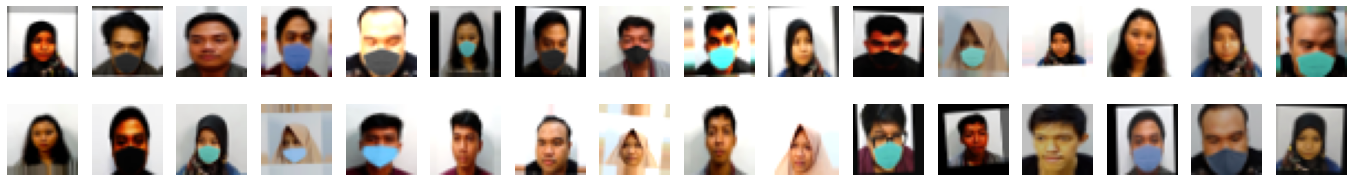

-----
(1174.09 ms) == (0m:1s)
-----


In [18]:
mulai_hitung_waktu()  ###

show_images(batch_size//2, sample_training_images)

cetak_lama_waktu()  ###

In [19]:
base_model = keras.applications.MobileNetV2(
    weights=None,  # 'imagenet'  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),  # square [96, 128, 160, 192, 224]
    alpha=1.0,  # network width multiplier, default 1.0 in the MobileNetV2 paper
    include_top=False)  # Do not include the ImageNet classifier at the top.

# base_model.trainable = False  # freeze the base model.

In [20]:
base_model.name

'mobilenetv2_1.00_32'

In [23]:
# Create a new model on top.

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
# This is important for fine-tuning, as you will learn in a few paragraphs.

# x = base_model(inputs, training=False)
x = base_model(inputs, training=True)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dropout(0.2)(x)

# Regularize with dropout
# x = keras.layers.Dropout(0.1)(x)
# x = keras.layers.Dense(256,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
# x = keras.layers.Dropout(0.1)(x)
# x = keras.layers.Dense(256,activation='relu')(x) #dense layer 2
# x = keras.layers.Dropout(0.1)(x)
# x = keras.layers.Dense(128,activation='relu')(x) #dense layer 3
# x = keras.layers.Dropout(0.05)(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(12, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name=f'mobilenetv2_1.00_{IMG_HEIGHT:d}-{batch_size:d}-12')  # -imagenet224

In [24]:
model.name

'mobilenetv2_1.00_32-32-12'

In [25]:
# Optimizer's scheduler: ExponentialDecay

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [26]:
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
loss_fn = 'categorical_crossentropy'
metrics=[
    'categorical_accuracy',
    keras.metrics.TopKCategoricalAccuracy(k=3, name='top-3'),
    keras.metrics.AUC(name='ROC-AUC', curve='ROC'),
    keras.metrics.AUC(name='PR-AUC', curve='PR'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.TruePositives(name='TP'),
    keras.metrics.TrueNegatives(name='TN'),
    keras.metrics.FalsePositives(name='FP'),
    keras.metrics.FalseNegatives(name='FN'),]

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=metrics)

In [27]:
model.summary()

Model: "mobilenetv2_1.00_32-32-12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_32 (Functio (None, 1, 1, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                15372     
Total params: 2,273,356
Trainable params: 2,239,244
Non-trainable params: 34,112
_________________________________________________________________


In [28]:
params = {
    'total_train' : total_train,
    'total_val' : total_val,
    'batch_size' : batch_size,
    'steps_per_epoch' : total_train//batch_size,
    'validation_steps' : total_val//batch_size,
    'epochs' : epochs}

display(params)

{'total_train': 9072,
 'total_val': 6048,
 'batch_size': 32,
 'steps_per_epoch': 283,
 'validation_steps': 189,
 'epochs': 50}

In [29]:
try:
    os.mkdir(f'{CHECKPOINTS_DIR}/{model.name}')
    print('success')
    print()
except FileExistsError:
    print('exist')
    
try:
    os.mkdir(f'{FINAL_EPOCH_DIR}/{model.name}')
    print('success')
    print()
except FileExistsError:
    print('exist')

success

success



In [30]:
# Model's callback: ModelCheckpoint


epoch_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='%s/%s/%s.weights.{epoch:03d}.hdf5' % (CHECKPOINT_DIR, model.name, model.name),
    monitor='val_loss',
    save_weights_only=True,
    save_freq=int(5 * params['steps_per_epoch'])
    )

acc_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='%s/%s/%s.weights.{epoch:03d}_{val_categorical_accuracy:.4f}_{val_loss:.4f}.hdf5' % (CHECKPOINT_DIR, model.name, model.name),
    monitor='val_categorical_accuracy',
    # verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=True,
    save_freq='epoch'
    )

loss_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='%s/%s/%s.weights.{epoch:03d}_{val_categorical_accuracy:.4f}_{val_loss:.4f}.hdf5' % (CHECKPOINT_DIR, model.name, model.name),
    monitor='val_loss',
    # verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=True,
    save_freq='epoch'
    )

# initialize tqdm callback with default parameters
# tqdm_callback = tfa.callbacks.TQDMProgressBar(
#     metrics_separator=', '
#     )

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir='%s/%s/%s.tensorboard' % (SAVED_WEIGHTS_MODELS, model.name, model.name)
    batch_size=batch_size,
    write_graph=True,
    write_grads=True,
    write_images=True
    )

callbacks = [
    epoch_checkpoint,
    acc_checkpoint,
    loss_checkpoint,
    # tqdm_callback,
    tensorboard_callback
    ]

In [31]:
mulai_hitung_waktu()  ###

training_history = model.fit(
    train_data_gen,
    shuffle=True,
    verbose=1,
    steps_per_epoch=total_train//batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val//batch_size,
    callbacks=callbacks,
    workers=0,
    )

cetak_lama_waktu()  ###
print(model.name)

Epoch 1/50
  1/283 [..............................] - ETA: 0s - loss: 3.1976 - categorical_accuracy: 0.0312 - top-3: 0.1250 - ROC-AUC: 0.4323 - PR-AUC: 0.0677 - precision: 0.0000e+00 - recall: 0.0000e+00 - TP: 0.0000e+00 - TN: 351.0000 - FP: 1.0000 - FN: 32.0000WARNING:tensorflow:From X:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
283/283 [==============================] - 147s 519ms/step - loss: 2.1137 - categorical_accuracy: 0.3993 - top-3: 0.6791 - ROC-AUC: 0.8385 - PR-AUC: 0.4216 - precision: 0.6393 - recall: 0.2310 - TP: 2088.0000 - TN: 98262.0000 - FP: 1178.0000 - FN: 6952.0000 - val_loss: 1.7648 - val_categorical_accuracy: 0.5385 - val_top-3: 0.8214 - val_ROC-AUC: 0.9061 - val_PR-AUC: 0.5746 - val_precision: 0.7302 - val_recall: 0.3361 - val_TP: 2033.0000 - val_TN: 65777.

In [32]:
model.save_weights(
    filepath=f'{SAVED_WEIGHTS_MODELS:s}/{model.name:s}/weights.{model.name:s}.h5',
    overwrite=True,
    save_format='h5'
    )

In [33]:
model.save(
    filepath=f'{SAVED_WEIGHTS_MODELS:s}/{model.name:s}/model.{model.name:s}.h5',
    overwrite=True,
    include_optimizer=True,
    save_format='h5'  # 'tf' 'h5'
    )

In [34]:
import pandas as pd

history_df = pd.DataFrame(training_history.history)

# save to csv: 
with open(f'{SAVED_WEIGHTS_MODELS:s}/{model.name:s}/history.{model.name:s}.csv', mode='w') as f:
    history_df.to_csv(
        f,
        header=True,
        index=False
        )

In [31]:
print('all process done')
print('''don't forget to save the model.fit() verbose output''')

all process done
don't forget to save the model.fit() verbose output
